# Modelo Ross-Macdonald - Ciclo Mosquitos - Huevos.

 Plantea un modelo **SIR - SI** donde se divide a la población en:

 * Humanos susceptibles.
 * Humanos Infectados.
 * Humanos Recuperados.

 y por el lado de los mosquitos:

 * Mosquitos susceptibles.
 * Mosquitos infectados.

 Además, a este modelo se le agregó la influencia de los huevos (H), los cuales dependen de la temperatura y las lluvias de una región dada.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from scipy.integrate import odeint

In [2]:
path = '../Datos/'
myfile = 'ClimaServicio5YRosario.csv'
fullname = path + myfile
clima5Y = pd.read_csv(
    fullname,
    na_values='\\N'    # convierte '\N' en NaN
)

#clima5Y = pd.read_csv(
#    'ClimaServicio5YRosario.csv',
#    na_values='\\N'    # convierte '\N' en NaN
#)

clima5Y['TMED'] = clima5Y['TMED'].ffill()
tmed5Y = np.array(clima5Y['TMED'], dtype=float)
clima5Y['PRECIP'] = clima5Y['PRECIP'].ffill()
precip5Y = np.array(clima5Y['PRECIP'], dtype=float)
lenClima5Y = len(clima5Y)
print(lenClima5Y)
print(tmed5Y)
print(precip5Y)

2131
[23.5        22.89999962 24.5        ... 13.30000019 16.10000038
 18.79999924]
[0. 0. 0. ... 0. 0. 0.]


# Modelo.

Por problemas del minimize en la parte de búsqueda de parámetros, conviene reemplazar $(H_s + H_i + H_r)$ por $N_h$.

De lo contrario por el funcionamiento interno de minimize, cada uno de esos compartimentos decrece demasiado y termina dividiendo por cero.



In [3]:
def RossMacdonaldCicloMosquitos_model(x,t, params):

    T= Temp(t) #temperatura

    # Desarmamos el vector
    Hs, Hi, Hr, Vs, Vi, H, L = x

    mu_v, r_h, beta_h, beta_v = params

    # Planteamos las ecuaciones
    dHs_dt = - beta_h * Vi * Hs/Nh
    dHi_dt = beta_h * Vi * Hs/Nh - r_h * Hi + imp #agregué casos importados
    dHr_dt = r_h * Hi
    # La ecuacion de abajo la corregí para tener en cuenta que los susceptibles al infectarse se restan. Además agregué que nacen de los infect.
    dVs_dt = alpha(T,L) * H - beta_v * Vs * Hi/Nh - mu_v * Vs # Modela ciclo de vida de mosquitos en funcion del tiempo
                                                                # alpha: Tasa de eclosión (respecto de la Temperatura y Nivel de Agua)
                                                                # mu_v: Tasa de mortalidad (parámetro fijo)

    dVi_dt = beta_v * Vs * Hi/Nh - mu_v * Vi
    dH_dt =  lam_v(T) * Vs * (1-H/Hm) - alpha(T,L) * H - mu_h * H  #lam_v es la tasa de ovoposición dependiente de la temperatura
    dL_dt = 1/7 * (P(t) - L)

    # Planteamos la ecuacion
    # alpha(t,L) devuelve una función que depende de la temperatura y la lluvia.

    return [dHs_dt, dHi_dt, dHr_dt, dVs_dt, dVi_dt, dH_dt, dL_dt]

# Parámetros.

In [4]:
# Parameters

mu_v = 1/10 # Tasa de mortalidad de los mosquitos.
mu_h = 1/150 # Tasa de mortalidad de los huevos.
Hm = 1e6 # Este parámetro es el número máximo de huevos (limitado por factores ambientales, humanos, etc)

beta_h=0.3 # Tasa de transmisión mosquito-humano
beta_v=0.3 # Tasa de transmisión humano-mosquito
r_h=0.2 # Tasa de recuperacion humanos

imp=1 #casos importados

lmin = 0
lmax = 15

tmin = 20
tmax = 30

tminHuevos = 23
tmaxHuevos = 28

# Alpha es la tasa de nacimiento de los huevos.
# Es el producto de dos funciones acumuladas alpha1(T)*alpha2(L),
# una depende de la temperatura y la otra del tiempo.
def alpha(T,L):
  return alpha1(L) * THuevos(T) # (alpha2)


def alpha1(L):

  # Si L es menor que pmin retorno 0
  if L <= lmin:
    return 0

  # Si L es mayor que pmax retorno 1
  if L >= lmax:
    return 1

  # Si está en el medio tiene que dar algo lineal
  return max (1 - abs ((L - lmax) / lmax) , 0)

# Precipitaciones
def P(t):
  index = int(np.floor(t))

  if index > len(precip5Y) - 1:
    return 0

  return precip5Y[index]

def THuevos(T):
  return max (1 - abs ((T - tmaxHuevos) / (tmaxHuevos - tminHuevos)) , 0)


def lam_v(T):
  return max (1 - abs ((T - tmax) / (tmax-tmin)) , 0)

def Temp(t): #returns the temperature at day t
  index = int(np.floor(t))

  if index > lenClima5Y - 1:
    return tmed5Y[lenClima5Y - 1]

  return tmed5Y[index]


# Condiciones iniciales.

In [5]:
# Initial conditions

Nh = 1e6    # Total population
Nv = 1000 # Total población de mosquitos

Hi_0 = 5
Hs_0 = Nh - Hi_0
Hr_0 = 0

Vi_0 = 1
Vs_0 = Nv # Total mosquitos susceptibles

H = 1000 # Huevos iniciales
L = 0   # Lluvia inicial, (ver que valor inicial iria)

x0 = [Hs_0, Hi_0, Hr_0, Vs_0, Vi_0, H, L] # Vector inicial

# Simulación del tiempo.

In [6]:
# Time solution -> Básicamente genera el eje x.
t_start = 0.0
t_end = lenClima5Y - 1 # Seis años
num_points = lenClima5Y # 1:1 para que se correspondan con los días
time_points = np.linspace(t_start, t_end, num_points) # Genera lenClimaRos5Y puntos entre 0 y lenClimaRos5Y - 1  equiespaciados.

# Cálculo de soluciones.

In [7]:
params = [mu_v, r_h, beta_h, beta_v]
sol = odeint(RossMacdonaldCicloMosquitos_model, x0, time_points,rtol=1e-6, atol=1e-9, args = (params,))

Hs = sol[:, 0]
Hi = sol[:, 1]
Hr = sol[:, 2]
Vs = sol[:, 3]
Vi = sol[:, 4]
H  = sol[:, 5]
L  = sol[:, 6]


indDet = 0.2 # Indice de deteccion - No se detectan todos los casos
CasosNuevos = indDet * beta_h * Vi * Hs/Nh # Usar esto como variable en una funcion
                                            # de saturacion. Ver el XMax de los datos
                                            # reales.
                                            # La idea es poder ajustar los valores que
                                            # da esto con los casos que pueden detectarse.

#Vs_norm = (Vs - Vs.min()) / (Vs.max() - Vs.min())

# Ploteo.

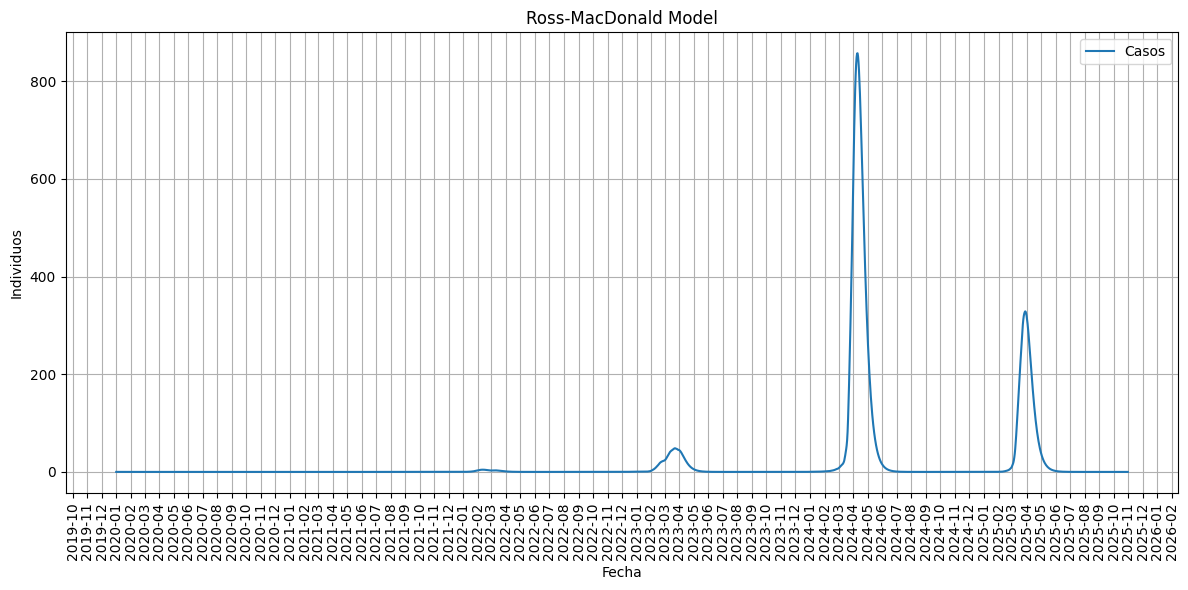

In [8]:
# Generar eje de fechas real
start_date = "2020-01-01"

date_index = pd.date_range(start=start_date, periods=lenClima5Y, freq='D')

plt.figure(figsize=(12, 6))
#plt.plot(date_index, Hr, label='Humanos recuperados')
#plt.plot(date_index, Vi, label='Vectores Infectados (Vi)')
#plt.plot(date_index, Hi, label='Humanos infectados (Hi)')
#plt.plot(date_index, Vs, label='Vectores Susceptibles (Vs)')
#plt.plot(date_index, H, label='Huevos')
plt.plot(date_index, CasosNuevos, label='Casos')

plt.title('Ross-MacDonald Model')
plt.xlabel('Fecha')
plt.ylabel('Individuos')
plt.grid(True)
plt.legend()

# ---- FORMATO DEL EJE X ----

# Mostrar solo meses
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=90)  # inclinamos las fechas
plt.tight_layout()
plt.show()

# Diferencia de Casos Reales vs Casos Modelo

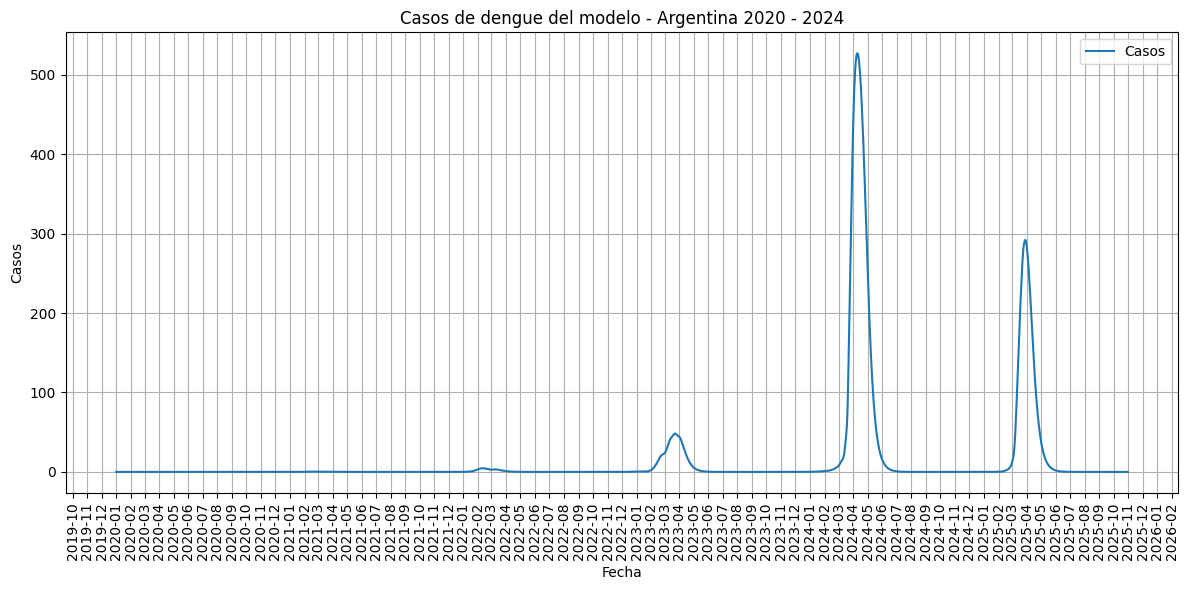

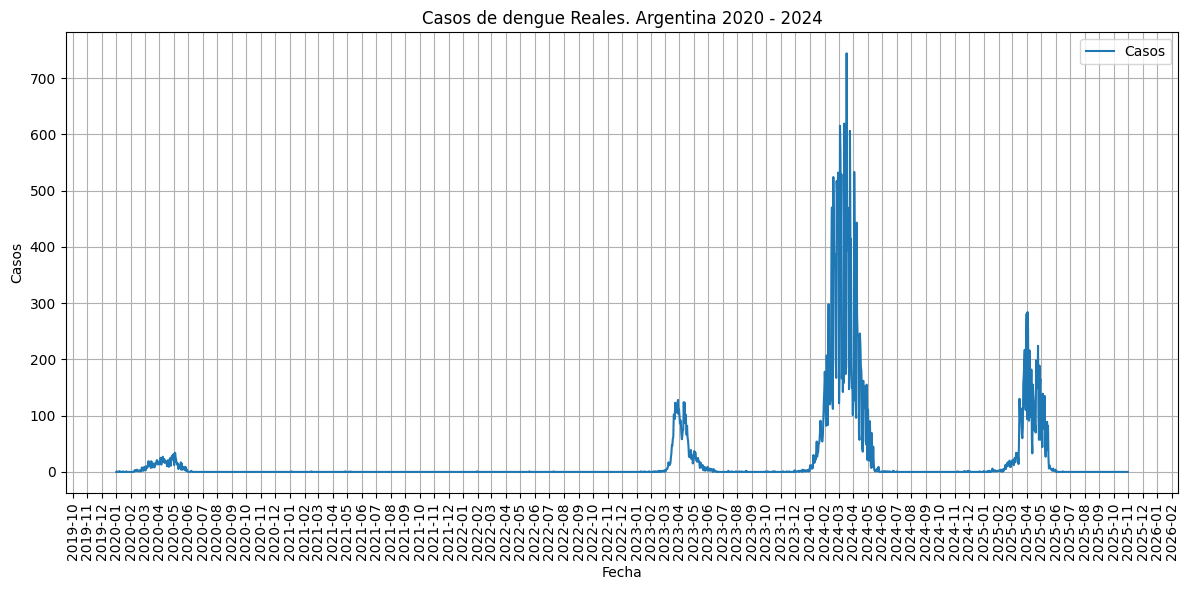

In [9]:
# Generar eje de fechas real
start_date = "2020-01-01"

date_index = pd.date_range(start=start_date, periods=lenClima5Y, freq='D')


path = '../Datos/'
myfile = 'CasosRosarioPorDia_20_25.csv'
fullname = path + myfile
casos5Y = pd.read_csv(
    fullname,
    na_values='\\N'    # convierte '\N' en NaN
)
casos5Y['Casos'] = casos5Y['Casos'].ffill()


maxContagios = 800

indDet = 0.2
CasosNuevos = indDet * beta_h * Vi * Hs/Nh # Usar esto como variable en una funcion
                                            # de saturacion. Ver el XMax de los datos
                                            # reales.
                                            # La idea es poder ajustar los valores que
                                            # da esto con los casos que pueden detectarse.

def saturar(nCasos):
  return maxContagios * (2/np.pi) * np.arctan((np.pi / 2) * (nCasos / maxContagios))

casosSaturados = saturar(CasosNuevos)

'''
Grafica de casos generada por el modelo luego de aplicar saturacion
'''

plt.figure(figsize=(12, 6))
plt.plot(date_index, casosSaturados, label='Casos')

plt.title('Casos de dengue del modelo - Argentina 2020 - 2024')
plt.xlabel('Fecha')
plt.ylabel('Casos')
plt.grid(True)
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=90)  # inclinamos las fechas
plt.tight_layout()
plt.show()


'''
Grafica de los casos reales
'''

casosReales = casos5Y['Casos']

min_len = min(lenClima5Y, len(casosReales))
x_plot = date_index[:min_len]
y_plot = casosReales[:min_len]


plt.figure(figsize=(12, 6))
plt.plot(x_plot, y_plot, label='Casos')

plt.title('Casos de dengue Reales. Argentina 2020 - 2024')
plt.xlabel('Fecha')
plt.ylabel('Casos')
plt.grid(True)
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=90)  # inclinamos las fechas
plt.tight_layout()
plt.show()
